# Code for loading and modifying datasets

In [1]:
# Utilities
from tqdm import tqdm_notebook as tqdm
import os
import pdb
import glob

# Numerical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing / Filtering
from scipy.ndimage import gaussian_filter1d

# Unsupervised learning: https://scikit-learn.org/stable/unsupervised_learning.html
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture

# My Utilities
import pulseoxLoader as loader

# Plots
%matplotlib notebook

In [2]:
data_path = "C:/Users/allen/Documents/OSCAR_Data-pulseox-data"
# print(os.listdir(data_path))
csv_path = os.path.join(data_path, '*.csv')
oxdata = loader.OxData(csv_path)
for file in glob.glob(csv_path):
    print(os.path.split(file)[-1])
example = os.path.join(data_path, 'OSCAR_allen_Details_2019-10-24.csv')

OSCAR_allen_Details_2019-10-08.3.csv
OSCAR_allen_Details_2019-10-24.csv
OSCAR_allen_Details_2019-10-26.csv
OSCAR_allen_Details_2019-11-14.csv
OSCAR_allen_Details_2019-11-14_11-15_2_sessions.csv


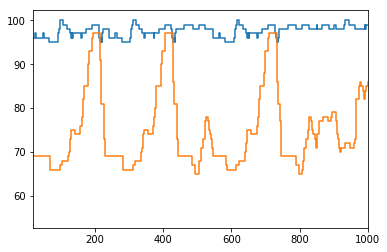

In [3]:
sp02, pulse, start_time = oxdata.day_to_df(example)
# print(sp02.head(2))
# print(pulse.head(2))
# print(start_time)
plt.clf()
plt.plot(sp02['DateTime'].values, sp02['Data/Duration'].values)
plt.plot(pulse['DateTime'].values, pulse['Data/Duration'].values)
plt.xlim(20, 1000)
plt.savefig(os.path.split(example)[-1] + '.png')
# 74720 time units for 32 minutes


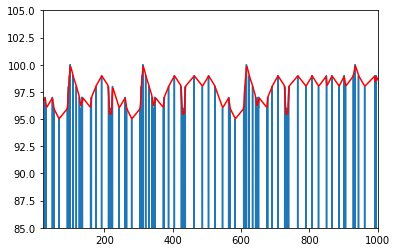

In [4]:
# Pre Processing for the FFT
wave = oxdata.preproc_df_fft(sp02, smoothing='gaussian', sigma=1, plot=True)


In [5]:
result = oxdata.gen_fft(wave, 1024)
print(result.shape)
magnitudes, angles = result[:,:result.shape[1]//2], result[:,result.shape[1]//2:]
idx = 70
# smoothing = 3
# moving_avg(magnitudes[idx], smoothing)
# moving_avg(angles[idx], smoothing)

(72, 1024)


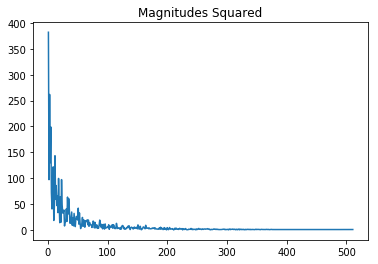

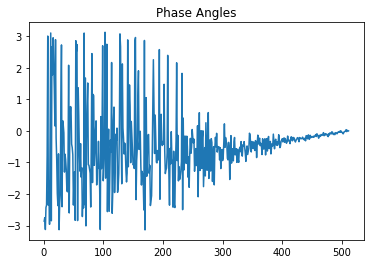

<Figure size 432x288 with 0 Axes>

In [6]:
oxdata.plot_fft(magnitudes[idx], angles[idx], offset=1)

In [7]:
# Normalize the data for each feature
X = normalize(result)
# Use PCA to reduce dimensionality of data. TODO: Investigate why samples were being dropped
# # reduce to number of samples, inc number of samples by shrinking windows
# pca = PCA(n_components=0.99, svd_solver='full') 
# pca.fit(X)
# print(pca.n_components_)
# Xn = pca.components_
# print(Xn.shape)
kmeans = KMeans(n_clusters=3) # TODO: Plot inertia vs number of clusters, and find 'elbow'
kmeans_pred = kmeans.fit_predict(X)
print("Inertia: {}".format(kmeans.inertia_))
# print("Cluster Centers: {}".format(kmeans.cluster_centers_))
print(kmeans.labels_)
print(kmeans_pred)
# mixture = GaussianMixture(n_components=3) #Output of GMM looks worse than kmeans for our application
# labels = mixture.fit_predict(X)
# # print(dir(mixture))


Inertia: 0.00037730088213270587
[2 2 2 2 2 2 2 1 1 1 1 2 1 2 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 1 1 1 1 2 1 2 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [8]:
X = oxdata.get_data_matrix()
print(X.shape)

(239, 2048)


In [9]:
Ks = [i+1 for i in range(10)]
inertias = []
for k in tqdm(Ks):
    kmeans = KMeans(n_clusters=k, n_jobs=-1)
    kmeans_pred = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)

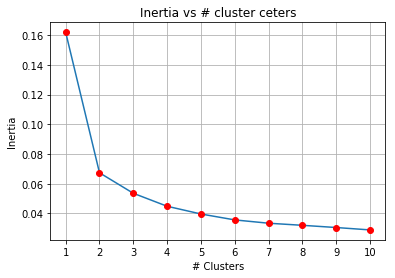

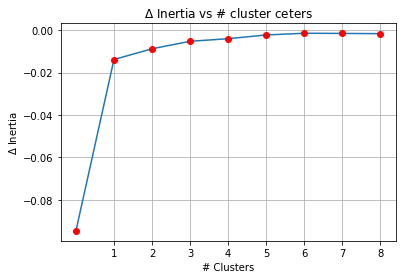

[-0.09466092708094068, -0.013802928899888163, -0.008741272703574443, -0.005214081181234884, -0.003984492637528085, -0.002227047615489121, -0.0014102802664870753, -0.001491959106570965, -0.0016092887432635067]


In [11]:
deltas = [inertias[i] - inertias[i-1] for i in range(1, len(inertias))]
plt.clf()
plt.title("Inertia vs # cluster ceters")
plt.xlabel("# Clusters")
plt.ylabel("Inertia")
plt.xticks(Ks)
plt.plot(Ks, inertias)
plt.plot(Ks, inertias, 'ro')
plt.grid()
plt.show()

plt.clf()
plt.title(r"$\Delta$ Inertia vs # cluster ceters")
plt.xlabel("# Clusters")
plt.ylabel(r"$\Delta$ Inertia")
plt.xticks(Ks)
plt.plot(deltas)
plt.plot(deltas, 'ro')
plt.grid()
plt.show()
print(deltas)